
# **Media Prediction Data Construction**

**Media/Culture Information**

1.1 MediaDive | Provides media IDs, components/annotations, associated taxa, and other relevant information

1.2 BacDive | Provides culture/isolation info, metabolic annotations (including EC and metabolites), and more (1.1)

**Taxa to EC**

2.1 UniProtKB (species) | Queries UniProtKB for ec numbers from an input of species names (1.1)

2.2 UniProtKB (taxon_id) | Queries UniProtKB for ec numbers from an input of NCBI taxon_id's (1.2)

2.3 Final taxa2ec dataframe | Formatting identifiers and associated ec numbers (1.2, 2.1, 2.3)

**Media to EC**

3.1 KEGG (KEGG CPD) | Queries KEGG for ec numbers from an input of KEGG compounds (1.1)


**EC to Cofactors**

4.1 Subsetting data based on isolation information

4.2 UniProtKB (ec) | Queries UniProtKB for cofactor information from an input of ec numbers (2.3, 3.1)

**Metabolites**

5.1 Formatting metabolite information from BacDive (1.2)

**Master Table**

6.1 Formatting master table (1.1, 1.2, 2.3, 3.1, 4.2, 5.1)


*Search terms: "final dataframe", "#SAVE", ...*

In [1]:
import pandas as pd
from tqdm import tqdm
from io import StringIO
import ast

# OS for reading/saving
import os
DATA_DIR = 'C:/Users/jakel/Desktop/code/data/'

# Requests for querying databases
import requests
import re
from requests.adapters import HTTPAdapter, Retry

## Media and Associated Taxa

### [1.1] MediaDive

Returns all information (media id's, components, component id's, characteristics, associated taxa information, etc.) used for subsequent analyses.

In [13]:
import modules.mediadive as md

Retrieve all MediaDive info

In [14]:
# Retrieve all available media from MediaDive
md_media_df = md.get_media()
md_media_df.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-media.csv"), index=False) #SAVE

In [15]:
# Create media_id_list
md_media_df = md_media_df.rename(columns={"id": "media_id"})
media_id_list = md_media_df["media_id"].astype(str).unique()

# Use media_id_list to retrieve media composition information
md_comp_df = md.get_composition(media_id_list)

# Use media_id_list to retrieve media-associated strain information
md_strains_df = md.get_strains(media_id_list)

md_comp_df.to_csv(os.path.join(DATA_DIR, "mediadive","mediadive-media-comp.csv"), sep=";", index=False) #SAVE
md_strains_df.to_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-media-strains.csv"), sep=";", index=False) #SAVE

  0%|          | 13/3315 [00:02<09:24,  5.85it/s]Exception ignored in: <finalize object at 0x28b0662e320; dead>
Traceback (most recent call last):
  File "c:\Users\jakel\anaconda3\envs\media\Lib\weakref.py", line 590, in __call__
    return info.func(*info.args, **(info.kwargs or {}))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\urllib3\connectionpool.py", line 1184, in _close_pool_connections
    conn.close()
  File "c:\Users\jakel\anaconda3\envs\media\Lib\site-packages\urllib3\connection.py", line 277, in close
    super().close()
  File "c:\Users\jakel\anaconda3\envs\media\Lib\http\client.py", line 1020, in close
    sock.close()   # close it manually... there may be other refs
    ^^^^^^^^^^^^
  File "c:\Users\jakel\anaconda3\envs\media\Lib\socket.py", line 504, in close
    self._real_close()
  File "c:\Users\jakel\anaconda3\envs\media\Lib\ssl.py", line 1311, in _real_close
    super()._real_close()
  File "c

Merge MediaDive outputs

In [ ]:
# Merge media composition and strains info
md_df = pd.merge(left=md_comp_df, right=md_strains_df, on="media_id", how="outer", indicator=True)

# Merge media information with original dataframe
md_df = pd.merge(left=md_media_df, right=md_df, on="media_id", how="left", indicator=False)

# Add extra column indicating the source of the data
md_df = md_df.rename(columns={"_merge": "merge_source"})
md_df["merge_source"] = md_df["merge_source"].cat.rename_categories({"right_only": "composition_only", "left_only": "strains_only"})

md_df.to_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep=";", index=False) #SAVE

**MediaDive final dataframe**

In [4]:
md_df = pd.read_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep = ';')
md_df.head()

,media_id,name,complex_medium,source,link,min_pH,max_pH,reference,description,components,component_ids,strain_id,species,ccno,bacdive_id,merge_source
0,1,NUTRIENT AGAR,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",29.0,Comamonas testosteroni,DSM 38,2912.0,both
2,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",30.0,Delftia acidovorans,DSM 39,2941.0,both
3,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",39.0,Acidovorax delafieldii,DSM 64,2885.0,both
4,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",52.0,Pseudomonas putida,DSM 84,12895.0,both


### [1.2] BacDive

Returns ec numbers, environmental info, metabolite data, taxonomic information, culturing info, and more from an input of bacdive_id's

In [ ]:
import bacdive
import modules.bacdive as bd

Initialize BacDive, prepare IDs

In [ ]:
# Retrieve bacdive_id's from the 'md_df' MediaDive table
md_df = pd.read_csv(os.path.join(DATA_DIR, "mediadive", "mediadive-all.csv"), sep=";")
bd_id_list = md_df["bacdive_id"].dropna().astype(int).astype(str).unique()
len(bd_id_list)

13735

Retrieval of BacDive info

In [ ]:
# Initialize client
client = bacdive.BacdiveClient('wjlowe03@gmail.com', 'UNINA_Bacdive')

step = 100
bacdive_df = []

for idx_start in tqdm(range(0, len(bd_id_list), step)): #status bar
    id_list = ";".join(bd_id_list[idx_start:idx_start+step]) 
    bacdive_df.append(bd.taxon2ec(id_list=id_list, client=client))

bacdive_df = pd.concat(bacdive_df, axis=0, ignore_index=True)
bacdive_df = bacdive_df.drop("reference", axis=1)

bacdive_df.to_csv(os.path.join(DATA_DIR, "bacdive", "bacdive-all.csv"), index=False) #SAVE

-- Authentication successful --


100%|██████████| 138/138 [03:01<00:00,  1.32s/it]


**BacDive final dataframe**

In [ ]:
bacdive_df = pd.read_csv(os.path.join(DATA_DIR, 'bacdive', 'bacdive-all.csv'), low_memory=False)
bacdive_df.head()

,general_@ref,bacdive_id,dsmz_id,general_keywords,general_description,taxon_id,ncbi_tax_id_matching_level,strain_history_@ref,strain_history_history,general_doi,...,api_id32sta_beta_gur,physiology_and_metabolism_murein,physiology_and_metabolism_api_list,isolation_enrichment_culture,isolation_enrichment_culture_temperature,multicellular_morphology_complex_color,api_list_beta_hem,metabolite_tests_citrate_test,compound_production_excreted,isolation_enrichment_culture_duration
0,21113,24370,11532.0,"['Bacteria', 'human pathogen']",Pseudomonas fluorescens PWD34 is a human patho...,294,species,21113.0,"<- W. Duetz, RIVM, Bilthoven; PWD34",10.13145/bacdive24370.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21111,24368,304.0,Bacteria,Pseudomonas sp. DSM 304 is a bacterium of the ...,306,species,21111.0,"<- IMG, 1591 (<i>P. fluorescens</i>) <- H. Stolp",10.13145/bacdive24368.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20542,23995,30059.0,Bacteria,Lelliottia amnigena 21824 is a bacterium that ...,61646,species,20542.0,<- Bakteriologisches Institut der Sueddeutsche...,10.13145/bacdive23995.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1479,17621,3849.0,"['16S sequence', 'Bacteria', 'plant pathogen']",Xanthomonas citri subsp. malvacearum XM13 is a...,346,species,NaN,NaN,10.13145/bacdive17621.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1480,17596,3850.0,"['genome sequence', 'Bacteria', 'obligate aero...",Xanthomonas campestris DSM 3850 is an obligate...,339,species,NaN,NaN,10.13145/bacdive17596.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Taxa to EC

### [2.1] UniProtKB taxa2ec (species name)

Returns ec numbers and identifier information from UniProtKB for an input of species (MediaDive)

In [ ]:
import modules.uniprotkb as uni

Format species name from the 'md_df' MediaDive dataframe for querying UniProtKB

In [ ]:
species_df = md_df.copy()
species_df['species'] = species_df['species'].replace(' ','+', regex=True)
species_list = set(species_df['species'].to_list())
len(species_list)

12391

Retrieval of UniProtKB info

In [ ]:
# Import and run function to retrieve ec's associated with each species
    # Note: currently, script only checks reviewed entries (SwissProt), and ignores 1000's of tREMBL entries
    # Errors represent where species are totally absent, whereas non-reviewed entries show as 'x species with no data'
    
uniprot_df = uni.species2ec(species_list)
uniprot_df.to_csv(os.path.join(DATA_DIR, "uniprot", "uniprot-all.csv"), index=False) #SAVE

Processing species:  48%|████▊     | 5911/12391 [14:55<14:24,  7.50it/s]  

HTTP error occurred for Protocrea+illino&euml;nsis: 400 Client Error: Bad Request for url: https://rest.uniprot.org/uniprotkb/search?fields=accession%2Cec%2Corganism_name%2Corganism_id%2Ccc_cofactor%2Cid&format=tsv&size=500&query=%28organism_name%3AProtocrea+illino&euml;nsis%29+AND+%28ec%3A*%29+AND+%28reviewed%3Atrue%29


Processing species:  75%|███████▌  | 9331/12391 [22:57<05:11,  9.83it/s]  

HTTP error occurred for Sphingobacterium+composti+[homonym]: 400 Client Error: Bad Request for url: https://rest.uniprot.org/uniprotkb/search?fields=accession%2Cec%2Corganism_name%2Corganism_id%2Ccc_cofactor%2Cid&format=tsv&size=500&query=%28organism_name%3ASphingobacterium+composti+%5Bhomonym%5D%29+AND+%28ec%3A*%29+AND+%28reviewed%3Atrue%29


Processing species: 100%|██████████| 12391/12391 [30:42<00:00,  6.73it/s] 


10660 species with no data


**UniProtKB (MediaDive species name) final dataframe**

In [ ]:
uniprot_df = pd.read_csv(os.path.join(DATA_DIR, "uniprot", "uniprot-all.csv"))

### [2.2] UniProtKB taxa2ec (taxon_id)

Combined approach: uses NCBI taxon_id's (species level) from BacDive to query UniProtKB

In [ ]:
import modules.uniprotkb as uni

Format taxon_id's to query UniProtKB

In [ ]:
import ast 

bacdive_df = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "bacdive-all.csv"), low_memory=False)
taxon_id = bacdive_df['taxon_id'].to_list()

# Some NCBI IDs are nested dictionaries, this should extract the ID at the species OR strain level:
data = taxon_id
tax_ids = []

# Loop to extract NCBI tax ids
for item in data:
    if isinstance(item, str) and item.startswith('[') and item.endswith(']'):
        # Parse the string representation of the list of dictionaries
        try:
            dicts = ast.literal_eval(item)
            for d in dicts:
                if d['Matching level'] == 'species':
                    tax_ids.append(d['NCBI tax id'])
        except (ValueError, SyntaxError):
            # Handle cases where the string is not a valid list of dictionaries
            continue

len(tax_ids)

2053

Retrieval of UniProtKB info

In [ ]:
ncbi_df = uni.taxon2ec(tax_ids)
ncbi_df['ec_uniprot'] = ncbi_df['ec_uniprot'].str.split('; ').explode('ec_uniprot')

ncbi_df.to_csv(os.path.join(DATA_DIR, 'bacdive', 'ncbi-ec.csv'), index=False) #SAVE

Processing species: 100%|██████████| 2053/2053 [29:56<00:00,  1.14it/s] 


503 species with no data


**UniProtKB (NCBI taxon IDs) final dataframe**

In [ ]:
ncbi_df = pd.read_csv(os.path.join(DATA_DIR, 'bacdive', 'ncbi-ec.csv'))
ncbi_df.head()

,species,ec_uniprot
0,231455,5.6.2.2
1,231455,2.7.7.6
2,33050,2.6.1.-
3,33050,3.1.1.87
4,33050,2.7.1.25


### [2.3] Formatting final taxa2ec table

Reformat outputs from [1.2-2.2]

In [2]:
bacdive_df = pd.read_csv(os.path.join(DATA_DIR, 'bacdive', 'bacdive-all.csv'), low_memory=False)
uniprot_df = pd.read_csv(os.path.join(DATA_DIR, 'uniprot', 'uniprot-all.csv'))
ncbi_df = pd.read_csv(os.path.join(DATA_DIR, 'bacdive', 'ncbi-ec.csv'))

# BacDive taxa2ec (grouped by bacdive_id)
bacdive_ec = bacdive_df[['bacdive_id','taxon_id','type_strain','ec']].copy()
bacdive_ec['ec'] = bacdive_ec['ec'].str.replace("'", "")
bacdive_ec = bacdive_ec.rename(columns={'ec': 'ec_bacdive'})

# UniProtKB taxa2ec (grouped by species name)
uniprot_ec = uniprot_df.copy()
uniprot_ec['species'] = uniprot_ec['species'].replace(r'\+',' ', regex=True)
uniprot_ec['ec_uniprot'] = uniprot_ec['ec_uniprot'].str.replace(";", ",")
uniprot_ec = uniprot_ec.groupby("species", as_index=False)["ec_uniprot"].apply(lambda x: "[%s]" % ', '.join(x))

# NCBI taxa2ec (grouped by taxon_id)
ncbi_ec = ncbi_df.astype(str).copy()
ncbi_ec = ncbi_ec.rename(columns={'species': 'taxon_id', 'ec_uniprot': 'ec_ncbi'})
ncbi_ec = ncbi_ec.groupby("taxon_id", as_index=False)["ec_ncbi"].apply(lambda x: "[%s]" % ', '.join(x))

Merge 'md_df' MediaDive dataframe with formatted outputs

In [8]:
media_df = md_df.copy()

# Completing merge in multiple steps since we're merging on different columns
merged1 = pd.merge(left = media_df, right = uniprot_ec, on = 'species', how = 'left')
merged2 = pd.merge(left = merged1, right = bacdive_ec, on = 'bacdive_id', how = 'left')
merged3 = pd.merge(left = merged2, right = ncbi_ec, on = 'taxon_id', how = 'left')

merged3.to_csv(os.path.join(DATA_DIR, "taxa2ec-expanded.csv"), index=False) #SAVE
merged3.head()

,media_id,name,complex_medium,source,link,min_pH,max_pH,reference,description,components,...,strain_id,species,ccno,bacdive_id,merge_source,ec_uniprot,taxon_id,type_strain,ec_bacdive,ec_ncbi
0,1,NUTRIENT AGAR,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...",...,29.0,Comamonas testosteroni,DSM 38,2912.0,both,"[2.6.1.1, 4.1.1.12, 1.13.11.74, 1.13.11.76, 1....",285,no,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]","[4.2.1.3, 4.2.1.99, 6.3.2.10, 2.3.1.241, 5.6.2..."
2,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...",...,30.0,Delftia acidovorans,DSM 39,2941.0,both,"[1.14.11.43, 1.14.11.44, 3.1.1.75, 2.4.2.1, 2....","[{'NCBI tax id': 1218107, 'Matching level': 's...",yes,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]",NaN
3,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...",...,39.0,Acidovorax delafieldii,DSM 64,2885.0,both,[1.1.1.37],47920,yes,"[3.2.1.51, 3.2.1.24, 3.2.1.52, 3.2.1.21, 3.2.1...",NaN
4,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,NaN,NaN,"['Peptone', 'Meat extract', 'Agar', 'Distilled...",...,52.0,Pseudomonas putida,DSM 84,12895.0,both,"[5.1.1.10, 5.3.3.1, 1.18.1.3, 1.2.98.1, 1.18.1...",303,no,"[3.2.1.21, 3.5.1.5, 3.5.3.6]","[2.7.7.23, 2.7.1.25, 2.7.7.4, 3.1.11.5, 5.6.2...."


**taxa2ec final dataframe**

In [ ]:
final_df = merged3[["media_id", "species", "taxon_id", "ec_uniprot", "ec_bacdive","ec_ncbi"]].copy()

# Melt ec columns and attribute ec source
final_df = final_df.melt(
    id_vars=["media_id", "species", "taxon_id"],
    value_vars=["ec_uniprot", "ec_bacdive", "ec_ncbi"],
    value_name="ec",
    var_name="source"
)

# Format source and ec columns
final_df["source"] = final_df["source"].str.replace("ec_", "")
final_df['ec'] = final_df['ec'].astype(str).copy()
final_df["ec"] = final_df["ec"].str.replace("[", "").str.replace("]", "")
final_df['ec'] = final_df['ec'].str.split(', ')
final_df = final_df.explode('ec')

# Remove rows with nan 'ec' values
final_df = final_df.copy()
substring = 'nan'
filter = final_df['ec'].str.contains(substring) # create filter
final_df = final_df[~filter]

#final_df.to_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), index=False) #SAVE
final_df

,media_id,species,taxon_id,source,ec
1,1a,Comamonas testosteroni,285,uniprot,2.6.1.1
1,1a,Comamonas testosteroni,285,uniprot,4.1.1.12
1,1a,Comamonas testosteroni,285,uniprot,1.13.11.74
1,1a,Comamonas testosteroni,285,uniprot,1.13.11.76
1,1a,Comamonas testosteroni,285,uniprot,1.14.13.23
...,...,...,...,...,...
92484,J1236,Thermus thermophilus,274,ncbi,6.1.1.16
92484,J1236,Thermus thermophilus,274,ncbi,2.5.1.145
92484,J1236,Thermus thermophilus,274,ncbi,1.1.1.37
92484,J1236,Thermus thermophilus,274,ncbi,5.2.1.8


## Media to EC

### [3.1] KEGG media2ec (CPD)

Returns ec numbers from KEGG for an input of CPDs (MediaDive)

In [ ]:
from Bio.KEGG import REST
import modules.mediadive as md
import modules.kegg as kegg

Retrieve KEGG and ChEBI compound IDs from an input of MediaDive 'component_ids'

In [ ]:
# Retrieve 'component_ids' from the 'md_df' MediaDive dataframe
md_df = pd.read_csv(os.path.join(DATA_DIR,"mediadive","mediadive-all.csv"), sep = ';')

comps_df = md_df[['media_id','components','component_ids']].copy()
comps_df['media_id'] = comps_df['media_id'].drop_duplicates()
comps_df = comps_df.dropna()

# Extract the component_ids into a list
comps_df['component_ids'] = comps_df['component_ids'].astype(str)

def extract_ids(comps_df, component_ids):
    id_set = set()  # Use a set to avoid duplicate IDs
    for ids in comps_df['component_ids']:
        id_list = eval(ids)  # Convert the string representation of the list to an actual list
        id_set.update(id_list)
    return list(id_set)

# Extract IDs
id_list = extract_ids(comps_df, 'ids')

Retrieve associated ECs for each compound

In [ ]:
# Retrieve compound IDs from component IDs (MediaDive)
compound_df = md.get_compounds(id_list)

# Making 'cpd_list' using the KEGG compound IDs
cpd_df = compound_df['KEGG cpd'].dropna().copy()
cpd_list = cpd_df.to_list()

# Retrieve ECs from CPDs
cpd2ec_df = kegg.compound2ec(cpd_list) # HTTP errors = no ECs associated with this compound on KEGG

# Merge dataframes with component_id, compound, and ec information
cpd_merge = pd.merge(left=compound_df, right=cpd2ec_df, on="KEGG cpd", how="outer")
cpd_merge = cpd_merge.drop_duplicates()

cpd_merge.to_csv(os.path.join(DATA_DIR,"kegg","kegg-compound-ec.csv"), index=False) #SAVE

100%|██████████| 763/763 [01:45<00:00,  7.26it/s]


HTTP error occurred for C00293: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/compound:C00293
HTTP error occurred for C00382: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/compound:C00382


Format final table for media2ec

**media2ec final dataframe**

In [ ]:
# Explode md_df on component_id
component_df = md_df.copy()
component_df['component_ids'] = md_df['component_ids'].str.strip('[]')
component_df['component_ids'] = component_df['component_ids'].str.split(', ').explode('component_ids')
component_df = component_df.rename(columns={'component_ids': 'component_id'})

# Merge md_df with media2ec (KEGG), remove NaN 'KEGG cpd' values
cpd_merge['component_id'] = cpd_merge['component_id'].astype(str)
comp_comp = pd.merge(left=component_df, right=cpd_merge, on='component_id', how='outer')
kegg2ec = comp_comp.loc[comp_comp['KEGG cpd'].notnull()].copy()
kegg2ec = kegg2ec.loc[kegg2ec['Enzyme'].notnull()]

#NOTE: not all 'component id's' have an associated 'KEGG compound', and not all 'KEGG compound's' have an associated 'Enzyme'...this means our final table has a loss of data from our original input
    #Can try to remedy the data loss by splitting complex media components into their simpler forms

# Load and format taxon_id's from bacdive dataframe
taxon_df = pd.read_csv(os.path.join(DATA_DIR,"bacdive","bacdive-all.csv"), low_memory=False)
taxon_df = taxon_df[['bacdive_id','taxon_id']]

# Merge taxon_id's to kegg2ec table
media_final = pd.merge(left=kegg2ec, right=taxon_df, on='bacdive_id', how='outer')

media_final = media_final[['media_id','taxon_id','component_id','KEGG cpd','Enzyme']].copy()
media_final = media_final.dropna(subset='Enzyme')

media_final.to_csv(os.path.join(DATA_DIR, "media2ec-final.csv"), index=False) #SAVE
media_final.head()
    #Two different model inputs: one with component id's, one with enzymes

,media_id,taxon_id,component_id,KEGG cpd,Enzyme
5,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",4,C00001,1.1.1.1 1.1.1.22 1.1.1.23 ...
15,J97,"[{'NCBI tax id': 104101, 'Matching level': 'sp...",37,C12486,1.14.-.-
16,J709,104098,199,C00369,2.4.1.1 2.4.1.18 2.4.1.19 ...
25,J709,"[{'NCBI tax id': 610245, 'Matching level': 'sp...",199,C00369,2.4.1.1 2.4.1.18 2.4.1.19 ...
36,J97,"[{'NCBI tax id': 1123227, 'Matching level': 's...",4,C00001,1.1.1.1 1.1.1.22 1.1.1.23 ...


**media2ec final dataframe (exploded)**

In [ ]:
media_final = pd.read_csv(os.path.join(DATA_DIR, "media2ec-final.csv"))

# Function to split the column by 6-9 spaces (variable delimitation...idk why)
def split_and_clean(value):
    # Split the string based on 6 to 9 spaces
    split_values = re.split(r'\s{6,9}', value)
    # Remove any remaining spaces from the split values
    split_values = [v.strip() for v in split_values]
    return split_values

# Split and Explode
media_final['split_column'] = media_final['Enzyme'].apply(split_and_clean).copy()
media_split = media_final.explode('split_column').reset_index(drop=True)
media_split = media_split.drop(columns=['Enzyme'])
media_split = media_split.rename(columns={'split_column': 'ec_KEGG'})

media_split['ec_KEGG'] = media_split['ec_KEGG'].dropna()
media_split.to_csv(os.path.join(DATA_DIR, "media2ec-explode.csv"), index=False) #SAVE
media_split.head()

,media_id,taxon_id,component_id,KEGG cpd,ec_KEGG
0,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",4,C00001,1.1.1.1
1,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",4,C00001,1.1.1.22
2,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",4,C00001,1.1.1.23
3,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",4,C00001,1.1.1.115
4,J97,"[{'NCBI tax id': 104101, 'Matching level': 'sp...",37,C12486,1.14.-.-


## EC to Cofactors

### [4.1] Subsetting data based on isolation information

Useful for selecting isolates from specific environments

In [10]:
bacdive_df = pd.read_csv('~/Desktop/code/data/bacdive/bacdive-all.csv', low_memory=False)
final_df = pd.read_csv('~/Desktop/code/data/taxa2ec-final.csv', low_memory=False)

# Retrieve isolation data from 'bacdive-all.csv'
iso_data = bacdive_df[['taxon_id', 'isolation,_sampling_and_environmental_information_isolation']].copy()
iso_data = iso_data.dropna()

# Example: filter for isolates from "thermal" sources
filtered_df = iso_data[iso_data['isolation,_sampling_and_environmental_information_isolation'].str.contains('thermal')]
#isolates = filtered_df['taxon_id'].to_list()

# Merge with info from 'taxa2ec-final.csv'
merge_iso = pd.merge(left=filtered_df, right=final_df, on='taxon_id', how='left')

#merge_iso.to_csv(os.path.join(DATA_DIR, "isolate-ec.csv"), index=False) #SAVE
merge_iso.head()

,taxon_id,"isolation,_sampling_and_environmental_information_isolation",media_id,species,source,ec
0,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,1.11.1.6
1,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,1.9.3.1
2,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,3.2.1.23
3,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,1.1.1.1
4,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,3.4.21.50


In [11]:
filtered_df.head()

,taxon_id,"isolation,_sampling_and_environmental_information_isolation"
17,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c..."
111,1273429,"[{'@ref': 21313, 'sample type': 'geothermally ..."
333,1482736,"[{'@ref': 22619, 'sample type': 'carbonaceous ..."
362,520764,"[{'@ref': 15560, 'sample type': 'microbial mat..."
399,908809,"[{'@ref': 14356, 'sample type': 'geothermal wa..."


### [4.2] UniProtKB ec2metals (EC)

Returns cofactor information for a list of ec numbers

In [ ]:
import modules.cofactors as cofactors

Format list of ec numbers

In [ ]:
# Load reference dataframe

df = pd.read_csv('~/Desktop/code/data/isolate-ec.csv', low_memory=False) #taxa2ec-final.csv media2ec-explode.csv isolate-ec.csv | compare inputs eventually

#final_ec_list = df['ec'].iloc[:50].to_list() #subset for first n
final_ec_list = df['ec'].to_list() #may have to change column name based on dataframe
final_ecs = set(final_ec_list) #remove duplicates in list

ec_list = list(final_ecs)

Retrieve cofactor information

In [ ]:
# Retrieve cofactors
cofactor_df = cofactors.ec2metals(ec_list)

# Format ec2metals output
cofactors = cofactor_df.drop_duplicates().copy()
cofactors = cofactors.dropna(subset=['CofactorExtracted']).copy()
# List out all cofactors
CofactorFinal = cofactors.drop_duplicates(subset=['Query EC','CofactorFinal']).copy()
CofactorFinal.to_csv(os.path.join(DATA_DIR, "cofactors", "cofactors-subset.csv"), index=False) #SAVE

# Group cofactors by EC
grouped_cofactors = CofactorFinal.groupby("Query EC", as_index=False)["CofactorFinal"].apply(lambda x: "[%s]" % ', '.join(x))
grouped_cofactors.to_csv(os.path.join(DATA_DIR, "cofactors", "cofactors-grouped-subset.csv"), index=False) #SAVE
grouped_cofactors.head()

 80%|████████  | 617/771 [12:30<03:45,  1.46s/it]  c:\Users\jakel\Desktop\code\notebooks\media-prediction\notebooks\test\modules\cofactors.py:120: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  cofactors_df["CofactorFinal"] = cofactors_df["CofactorFinal"].fillna(
100%|██████████| 771/771 [15:30<00:00,  1.21s/it]


,Query EC,CofactorFinal
0,1.-.-.-,"[Fe, Zn, S, Mg, L-ascorbate, thiamine diphosph..."
1,1.1.1.-,"[Zn, Mg, metal, K, FAD, Fe, S, Ni, FMN, Mn, Cu..."
2,1.1.1.1,"[Zn, Fe]"
3,1.1.1.103,[Zn]
4,1.1.1.205,[K]


Format a table for machine learning model

In [22]:
ec_source = pd.read_csv(os.path.join(DATA_DIR, "media2ec-explode.csv"), low_memory=False) 
#ec_source = ec_source.rename(columns={"ec_KEGG": "ec"}) #for media2ec (KEGG)

ec2cofactor_df = pd.read_csv(os.path.join(DATA_DIR, "cofactors", "cofactors-media2ec.csv"), low_memory=False) #CHANGE DEPENDING ON DESIRED MODEL
ec2cofactor_df = ec2cofactor_df.rename(columns={"Query EC": "ec"})

cofactor_model = pd.merge(left=ec_source, right=ec2cofactor_df, on="ec", how="left")
cofactor_model = cofactor_model[["media_id","taxon_id", "ec", "CofactorFinal"]]

cofactor_model.to_csv(os.path.join(DATA_DIR, "cofactors", "cofactor-model-media.csv"), index=False) #SAVE
cofactor_model.head()

,media_id,taxon_id,ec,CofactorFinal
0,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",1.1.1.1,Zn
1,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",1.1.1.1,Fe
2,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",1.1.1.22,NaN
3,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",1.1.1.23,Zn
4,J597,"[{'NCBI tax id': 1226664, 'Matching level': 's...",1.1.1.23,pyridoxal 5'-phosphate


## Metabolites

### [5.1] Formatting metabolite information (BacDive)

General metabolite information

In [2]:
bacdive_df = pd.read_csv(os.path.join(DATA_DIR, 'bacdive', 'bacdive-all.csv'), low_memory=False) #Additonal references and other info also available

mtblt = bacdive_df[[
    "bacdive_id",
     "taxon_id",
     "compound_production_compound",
     "metabol_uti",
     "chebi_id",
     "metabol_name",
     "metabol_production", 
     "isolation,_sampling_and_environmental_information_isolation"
]].copy()

mtblt.to_csv(os.path.join(DATA_DIR, "bacdive", "metabolites.csv"), index=False) #SAVE
mtblt.head()

,bacdive_id,taxon_id,compound_production_compound,metabol_uti,chebi_id,metabol_name,metabol_production,"isolation,_sampling_and_environmental_information_isolation"
0,24370,294,trans carveol,"[{'@ref': 68369, 'Chebi-ID': 25115, 'metabolit...",35581.0,indole,no,NaN
1,24368,306,NaN,"[{'@ref': 68371, 'metabolite': 'Potassium 5-ke...",35581.0,indole,no,NaN
2,23995,61646,NaN,NaN,NaN,NaN,NaN,NaN
3,17621,346,restriction endonuclease <i>XmaI</i>,NaN,NaN,NaN,NaN,"[{'@ref': 1479, 'sample type': 'plant (cotton)..."
4,17596,339,restriction endonuclease <i>Xba</i>I,"[{'@ref': 117115, 'Chebi-ID': 16947, 'metaboli...",35581.0,indole,no,"[{'@ref': 1480, 'sample type': '<I>Xanthium st..."


Metabolite Utilization

In [3]:
# Function to parse through metabol_uti information and explode into new columns

def expand_dict_list(df, column):
    # Convert the string representation of the list of dictionaries into actual lists
    df[column] = df[column].apply(ast.literal_eval)
    
    # Explode the column with lists of dictionaries to individual rows
    df_expanded = df.explode(column).reset_index(drop=True)
    
    # Normalize the dictionaries into a flat dataframe
    expanded_rows = pd.json_normalize(df_expanded[column])
    
    # Combine the original dataframe (excluding the original column) with the expanded rows
    result = pd.concat([df_expanded.drop(columns=[column]), expanded_rows], axis=1)
    
    return result

In [4]:
# Format mtblt dataframe to apply function (string type, no na/Nan/nan)
mtblt["metabol_uti"] = mtblt["metabol_uti"].astype(str)
mtblt["metabol_uti"] = mtblt["metabol_uti"].dropna()
filter = mtblt["metabol_uti"].str.contains("nan")
mtblt = mtblt[~filter]

# Apply function
expanded_df = expand_dict_list(mtblt, 'metabol_uti')

# Reapply nan filter for the newly expanded data
expanded_df = expanded_df.copy()
expanded_df["utilization activity"] = expanded_df["utilization activity"].astype(str)
expanded_df["utilization activity"] = expanded_df["utilization activity"].dropna()
filter2 = expanded_df["utilization activity"].str.contains("nan")
expanded_df = expanded_df[~filter2]

# Filter for utilization activity (+)
#filter3 = expanded_df["utilization activity"].str.contains(r"\+")
#expanded_df = expanded_df[filter3]

# Subset and save metabolite utilization information
metabol_uti = expanded_df[[
    "bacdive_id",
    "taxon_id",
    "Chebi-ID",
    "metabolite",
    "utilization activity",
    "kind of utilization tested",
    "isolation,_sampling_and_environmental_information_isolation"
    ]]
metabol_uti = metabol_uti.rename(columns={
    "Chebi-ID": "chebi_id",
    "isolation,_sampling_and_environmental_information_isolation": "isolation_info"
    })

metabol_uti.to_csv(os.path.join(DATA_DIR, "bacdive", "metabol_uti.csv"), index=False) #SAVE
metabol_uti.head()

,bacdive_id,taxon_id,chebi_id,metabolite,utilization activity,kind of utilization tested,isolation_info
0,24370,294,25115.0,malate,+,assimilation,NaN
1,24370,294,17128.0,adipate,-,assimilation,NaN
2,24370,294,27689.0,decanoate,+,assimilation,NaN
3,24370,294,24265.0,gluconate,+,assimilation,NaN
4,24370,294,17306.0,maltose,-,assimilation,NaN


Metabolite Production

In [5]:
mtblt["metabol_production"] = mtblt["metabol_production"].astype(str).copy()

# Subset rows with confirmed metabolite production
substring = 'yes'
filter = mtblt["metabol_production"].str.contains(substring)
metabol_pro = mtblt[filter]

# Subset and save metabolite production information
metabol_pro = metabol_pro[[
    "bacdive_id",
    "taxon_id",
    "chebi_id",
    "metabol_name",
    "metabol_production",
    "isolation,_sampling_and_environmental_information_isolation"
    ]]
metabol_pro = metabol_pro.rename(columns={
    "metabol_name": "metabolite",
    "isolation,_sampling_and_environmental_information_isolation": "isolation_info"
    })

metabol_pro.to_csv(os.path.join(DATA_DIR, "bacdive", "metabol_pro.csv"), index=False) #SAVE
metabol_pro.head()

,bacdive_id,taxon_id,chebi_id,metabolite,metabol_production,isolation_info
63,5030,29488,35581.0,indole,yes,NaN
95,347,75697,35581.0,indole,yes,"[{'@ref': 4618, 'sample type': 'ditch in a for..."
96,346,75697,35581.0,indole,yes,"[{'@ref': 4617, 'sample type': 'activated slud..."
180,5050,1004166,35581.0,indole,yes,"[{'@ref': 16317, 'sample type': '<i>Heterorhab..."
181,5036,2218628,35581.0,indole,yes,"[{'@ref': 5632, 'sample type': 'nematode <I>He..."


## And so on and so on

### Master Table ###

In [11]:
# Subsetting MediaDive dataframe
md_df = pd.read_csv(os.path.join(DATA_DIR,"taxa2ec-expanded.csv"), low_memory=False)

# Format pH data as a range
def create_range(row):
    if row['min_pH'] == row['max_pH']:
        return f"{row['min_pH']}"
    else:
        return f"{row['min_pH']}-{row['max_pH']}"
    
md_df['pH'] = md_df.apply(create_range, axis=1)

md_df = md_df[["media_id", "name", "pH","components", "component_ids", "species", "ccno", "bacdive_id", "ec_bacdive","ec_uniprot","ec_ncbi"]]
md_df

,media_id,name,pH,components,component_ids,species,ccno,bacdive_id,ec_bacdive,ec_uniprot,ec_ncbi
0,1,NUTRIENT AGAR,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Comamonas testosteroni,DSM 38,2912.0,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]","[2.6.1.1, 4.1.1.12, 1.13.11.74, 1.13.11.76, 1....","[4.2.1.3, 4.2.1.99, 6.3.2.10, 2.3.1.241, 5.6.2..."
2,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Delftia acidovorans,DSM 39,2941.0,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]","[1.14.11.43, 1.14.11.44, 3.1.1.75, 2.4.2.1, 2....",NaN
3,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Acidovorax delafieldii,DSM 64,2885.0,"[3.2.1.51, 3.2.1.24, 3.2.1.52, 3.2.1.21, 3.2.1...",[1.1.1.37],NaN
4,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Pseudomonas putida,DSM 84,12895.0,"[3.2.1.21, 3.5.1.5, 3.5.3.6]","[5.1.1.10, 5.3.3.1, 1.18.1.3, 1.2.98.1, 1.18.1...","[2.7.7.23, 2.7.1.25, 2.7.7.4, 3.1.11.5, 5.6.2...."
...,...,...,...,...,...,...,...,...,...,...,...
31897,P5,RS Medium - Nutrient Medium (NM) Component,7.0,[],[],NaN,NaN,NaN,NaN,NaN,NaN
31898,P6,mTA10,7.2,[],[],NaN,NaN,NaN,NaN,NaN,NaN
31899,P7,N27 RHODOSPIRILLACEAE MEDIUM (modified),6.8,[],[],NaN,NaN,NaN,NaN,NaN,NaN
31900,P8,M9-SNG medium,7.2,[],[],NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Formatting BacDive dataframe (NCBI IDs are funky)

bacdive = pd.read_csv(os.path.join(DATA_DIR, "bacdive", "bacdive-all.csv"), low_memory=False)
bacdive = bacdive[["bacdive_id","taxon_id", "ncbi_tax_id_matching_level", "type_strain", "isolation,_sampling_and_environmental_information_isolation"]]

# Parsing cluster fuck NCBI IDs [{},{},{}, ... ] ...
ncbi_tax_ids = []
matching_levels = []

for item in bacdive['taxon_id']:
    tax_id = None  # Default to None if no species-level match is found
    matching_level = None  # Default to None if no species-level match is found
    if isinstance(item, str) and item.startswith('[') and item.endswith(']'):
        try:
            dicts = ast.literal_eval(item)
            for d in dicts:
                if d.get('Matching level') == 'species':
                    tax_id = d.get('NCBI tax id')
                    matching_level = 'species'
                    break  # Stop after finding the first match at the species level
        except (ValueError, SyntaxError):
            tax_id = None  # Handle cases where the string is not a valid list of dictionaries
            matching_level = None
    ncbi_tax_ids.append(tax_id)
    matching_levels.append(matching_level)

# Reformatting of dataframes
parsed = pd.DataFrame(columns=["taxon_id", "ncbi_tax_id_matching_level"])
parsed["taxon_id"] = ncbi_tax_ids
parsed["taxon_id"] = parsed["taxon_id"].astype(str)
parsed["ncbi_tax_id_matching_level"] = matching_levels
NaN = parsed["taxon_id"].str.contains("NaN")
parsed = parsed[~NaN].dropna()

# Concattonating dataframes
taxa = [bacdive, parsed]
ncbi = pd.concat(taxa)
ncbi["taxon_id"] = ncbi["taxon_id"].astype(str)
NaN = ncbi["taxon_id"].str.contains("NaN")
bd_df = ncbi[~NaN].dropna()
bd_df = bd_df[["bacdive_id","taxon_id", "type_strain", "isolation,_sampling_and_environmental_information_isolation"]]

bd_df.head()

,bacdive_id,taxon_id,type_strain,"isolation,_sampling_and_environmental_information_isolation"
3,17621.0,346,yes,"[{'@ref': 1479, 'sample type': 'plant (cotton)..."
4,17596.0,339,no,"[{'@ref': 1480, 'sample type': '<I>Xanthium st..."
5,17558.0,128780,no,"[{'@ref': 4910, 'sample type': 'industrial was..."
6,17504.0,128785,yes,"[{'@ref': 6768, 'sample type': 'biomass slugde..."
7,17502.0,83619,yes,"[{'@ref': 4678, 'sample type': 'experimental b..."


In [13]:
dive = pd.merge(left=md_df, right=bd_df, on="bacdive_id", how="left")
dive.head()

,media_id,name,pH,components,component_ids,species,ccno,bacdive_id,ec_bacdive,ec_uniprot,ec_ncbi,taxon_id,type_strain,"isolation,_sampling_and_environmental_information_isolation"
0,1,NUTRIENT AGAR,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Comamonas testosteroni,DSM 38,2912.0,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]","[2.6.1.1, 4.1.1.12, 1.13.11.74, 1.13.11.76, 1....","[4.2.1.3, 4.2.1.99, 6.3.2.10, 2.3.1.241, 5.6.2...",NaN,NaN,NaN
2,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Delftia acidovorans,DSM 39,2941.0,"[1.9.3.1, 3.2.1.21, 3.5.1.5, 3.5.3.6]","[1.14.11.43, 1.14.11.44, 3.1.1.75, 2.4.2.1, 2....",NaN,NaN,NaN,NaN
3,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Acidovorax delafieldii,DSM 64,2885.0,"[3.2.1.51, 3.2.1.24, 3.2.1.52, 3.2.1.21, 3.2.1...",[1.1.1.37],NaN,47920,yes,"[{'@ref': 2047, 'sample type': 'soil, enrichme..."
4,1a,REACTIVATION WITH LIQUID MEDIUM 1,7.0,"['Peptone', 'Meat extract', 'Agar', 'Distilled...","[1, 2, 3, 4]",Pseudomonas putida,DSM 84,12895.0,"[3.2.1.21, 3.5.1.5, 3.5.3.6]","[5.1.1.10, 5.3.3.1, 1.18.1.3, 1.2.98.1, 1.18.1...","[2.7.7.23, 2.7.1.25, 2.7.7.4, 3.1.11.5, 5.6.2....",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31897,P5,RS Medium - Nutrient Medium (NM) Component,7.0,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31898,P6,mTA10,7.2,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31899,P7,N27 RHODOSPIRILLACEAE MEDIUM (modified),6.8,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31900,P8,M9-SNG medium,7.2,[],[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### KEGG Orthology

In [2]:
taxa_ec = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)

filter = taxa_ec["ec"].str.contains("-")
taxa_ec = taxa_ec[~filter]
taxa_ec.head()

,media_id,species,taxon_id,source,ec
0,1a,Comamonas testosteroni,285,uniprot,2.6.1.1
1,1a,Comamonas testosteroni,285,uniprot,4.1.1.12
2,1a,Comamonas testosteroni,285,uniprot,1.13.11.74
3,1a,Comamonas testosteroni,285,uniprot,1.13.11.76
4,1a,Comamonas testosteroni,285,uniprot,1.14.13.23


In [4]:
ec_list = taxa_ec["ec"].to_list()
ec_list = set(ec_list)
ec_list = list(ec_list)
len(ec_list)

3879

In [5]:
import requests
import pandas as pd
from Bio.KEGG import REST
import modules.kegg as kegg

ec2ko_df = kegg.ec2ko(ec_list)

#ec2ko_df.to_csv(os.path.join(DATA_DIR, 'kegg', 'ec2ko-taxa.csv'), index=False) #SAVE
ec2ko_df.head()

### use the taxa2ec and media2ec lists as inputs, then use KEGG decoder

HTTP error occurred for 1.2.1.n2: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:1.2.1.n2
HTTP error occurred for 2.3.1.n5: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:2.3.1.n5
HTTP error occurred for 2.3.1.n4: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:2.3.1.n4
HTTP error occurred for 2.3.1.n7: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:2.3.1.n7
HTTP error occurred for 4.2.2.n1: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:4.2.2.n1
HTTP error occurred for 3.2.1.n1: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:3.2.1.n1
HTTP error occurred for 4.2.2.n2: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:4.2.2.n2
HTTP error occurred for 3.6.5.n1: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:3.6.5.n1
HTTP error occurred for 1.14.19.n5: 404 Client Error: Not Found for url: https://rest.kegg.jp/get/ec:1.14.19.n5
HTTP error occurred for 

,ec,KO
0,5.4.2.7,K01839 phosphopentomutase; K15779 phosphoglu...
1,1.4.1.2,K00260 glutamate dehydrogenase; K15371 gluta...
2,2.7.4.2,K00938 phosphomevalonate kinase; K13273 phos...
3,1.5.5.2,K00318 proline dehydrogenase; K13821 RHH-typ...
4,2.3.1.223,"K02615 3-oxo-5,6-didehydrosuberyl-CoA/3-oxoad..."


Merge on taxa2ec-final table

In [8]:
taxa_ec2 = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)
merged = pd.merge(left=taxa_ec2, right=ec2ko_df, on="ec", how="left")

#merged.to_csv(os.path.join(DATA_DIR, 'ec2ko-taxa.csv'), index=False) #SAVE
merged.head()

,media_id,species,taxon_id,source,ec,KO
0,1a,Comamonas testosteroni,285,uniprot,2.6.1.1,"K00811 aspartate aminotransferase, chloroplas..."
1,1a,Comamonas testosteroni,285,uniprot,4.1.1.12,K09758 aspartate 4-decarboxylase
2,1a,Comamonas testosteroni,285,uniprot,1.13.11.74,K15059 2-aminophenol/2-amino-5-chlorophenol 1...
3,1a,Comamonas testosteroni,285,uniprot,1.13.11.76,K15059 2-aminophenol/2-amino-5-chlorophenol 1...
4,1a,Comamonas testosteroni,285,uniprot,1.14.13.23,K19065 3-hydroxybenzoate 4-monooxygenase


Filter for thermophiles

In [13]:
# Retrieve isolation data from 'bacdive-all.csv'
bacdive_df = pd.read_csv('~/Desktop/code/data/bacdive/bacdive-all.csv', low_memory=False)

iso_data = bacdive_df[['taxon_id', 'isolation,_sampling_and_environmental_information_isolation']].copy()
iso_data = iso_data.dropna()

# Filter for isolates from "thermal" sources
filtered_df = iso_data[iso_data['isolation,_sampling_and_environmental_information_isolation'].str.contains('thermal')]
#isolates = filtered_df['taxon_id'].to_list()

# Merge with info from media-taxa-ec-ko table above
merge_iso = pd.merge(left=filtered_df, right=merged, on='taxon_id', how='left')

#merge_iso.to_csv(os.path.join(DATA_DIR, "ec2ko-thermal.csv"), index=False) #SAVE
merge_iso.head()

,taxon_id,"isolation,_sampling_and_environmental_information_isolation",media_id,species,source,ec,KO
0,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,1.11.1.6,K03781 catalase; K07217 manganese catalase; ...
1,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,1.9.3.1,
2,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,3.2.1.23,K01190 beta-galactosidase; K12111 evolved be...
3,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,1.1.1.1,K00001 alcohol dehydrogenase; K00121 S-(hydr...
4,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",1a,Pseudomonas azotifigens,bacdive,3.4.21.50,K01337 lysyl endopeptidase


In [39]:
# Format a list of organisms to use for taxonomic analysis
thermophiles = merge_iso.copy()
thermophiles = thermophiles[["taxon_id","isolation,_sampling_and_environmental_information_isolation","species"]]
thermophiles = thermophiles.drop_duplicates()
thermophiles.head()

,taxon_id,"isolation,_sampling_and_environmental_information_isolation",species
0,"[{'NCBI tax id': 291995, 'Matching level': 'sp...","[{'@ref': 6972, 'sample type': 'hyperthermal c...",Pseudomonas azotifigens
63,1273429,"[{'@ref': 21313, 'sample type': 'geothermally ...",NaN
64,1482736,"[{'@ref': 22619, 'sample type': 'carbonaceous ...",NaN
65,520764,"[{'@ref': 15560, 'sample type': 'microbial mat...",NaN
66,908809,"[{'@ref': 14356, 'sample type': 'geothermal wa...",Caloramator mitchellensis


Format NCBI taxon_id's for multiple levels (use species level)

In [40]:
# Parsing cluster fuck NCBI IDs [{},{},{}, ... ] ...
ncbi_tax_ids = []
matching_levels = []

for item in thermophiles['taxon_id']:
    tax_id = None  # Default to None if no species-level match is found
    matching_level = None  # Default to None if no species-level match is found
    if isinstance(item, str) and item.startswith('[') and item.endswith(']'):
        try:
            dicts = ast.literal_eval(item)
            for d in dicts:
                if d.get('Matching level') == 'species':
                    tax_id = d.get('NCBI tax id')
                    matching_level = 'species'
                    break  # Stop after finding the first match at the species level
        except (ValueError, SyntaxError):
            tax_id = None  # Handle cases where the string is not a valid list of dictionaries
            matching_level = None
    ncbi_tax_ids.append(tax_id)
    matching_levels.append(matching_level)

# Reformatting of dataframes
parsed = pd.DataFrame(columns=["taxon_id", "ncbi_tax_id_matching_level"])
parsed["taxon_id"] = ncbi_tax_ids
parsed["taxon_id"] = parsed["taxon_id"].astype(str)
parsed["ncbi_tax_id_matching_level"] = matching_levels
NaN = parsed["taxon_id"].str.contains("NaN")
parsed = parsed[~NaN].dropna()

# Concattonating dataframes
taxa = [thermophiles, parsed]
ncbi = pd.concat(taxa)
ncbi["taxon_id"] = ncbi["taxon_id"].astype(str)
old = ncbi["taxon_id"].str.contains("Matching level")
df = ncbi[~old]
df = df[["taxon_id", "species", "isolation,_sampling_and_environmental_information_isolation"]]

df.head()

,taxon_id,species,"isolation,_sampling_and_environmental_information_isolation"
63,1273429,NaN,"[{'@ref': 21313, 'sample type': 'geothermally ..."
64,1482736,NaN,"[{'@ref': 22619, 'sample type': 'carbonaceous ..."
65,520764,NaN,"[{'@ref': 15560, 'sample type': 'microbial mat..."
66,908809,Caloramator mitchellensis,"[{'@ref': 14356, 'sample type': 'geothermal wa..."
68,1170224,NaN,"[{'@ref': 19337, 'sample type': 'water from a ..."


In [52]:
# Make a list of IDs for taxonomy
tree = df.copy()
# Remove '.0' decimal places; float to integer
tree["taxon_id"] = tree["taxon_id"].astype(float)
tree["taxon_id"] = tree["taxon_id"].astype(int)
# Make list
taxa = tree["taxon_id"].to_list()
ncbi = {"ncbi_id": taxa}
ncbi_input = pd.DataFrame(ncbi).astype(str)

ncbi_input.to_csv(os.path.join(DATA_DIR, "thermophiles.txt"), index=False)

### Concentration Mapping

In [31]:
# Load dataframe with CoCl2 media concentrations
cocl = pd.read_csv(os.path.join(DATA_DIR, "CoCl2_trimmed.csv"))
cocl.head()

,solution,media_id,CoCl2
0,Media,150a,0.60
1,Media,379,0.19
2,Media,533,0.00
3,Media,141,0.10
4,Media,882,0.64


In [32]:
# Load dataframe with EC annotations
ec = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)
ec.head()

,media_id,species,taxon_id,source,ec
0,1a,Comamonas testosteroni,285,uniprot,2.6.1.1
1,1a,Comamonas testosteroni,285,uniprot,4.1.1.12
2,1a,Comamonas testosteroni,285,uniprot,1.13.11.74
3,1a,Comamonas testosteroni,285,uniprot,1.13.11.76
4,1a,Comamonas testosteroni,285,uniprot,1.14.13.23


In [33]:
# Merge these dataframes to associate ec values w/ concentrations
coan = pd.merge(left=cocl, right=ec, on="media_id", how="left")
coec = coan.dropna(subset=["ec"])
filter = coec["ec"].str.contains("-")
coec = coec[~filter]
coec

,solution,media_id,CoCl2,species,taxon_id,source,ec
0,Media,150a,0.60,Acidithiobacillus caldus,"[{'NCBI tax id': 33059, 'Matching level': 'spe...",uniprot,2.4.1.13
13,Allen,88a,0.00,Vulcanisaeta distributa,"[{'NCBI tax id': 164451, 'Matching level': 'sp...",uniprot,2.5.1.157
14,Allen,88a,0.00,Vulcanisaeta distributa,"[{'NCBI tax id': 164451, 'Matching level': 'sp...",uniprot,5.4.99.25
21,Allen,358a,0.00,Acidianus ambivalens,2283,uniprot,1.8.5.2
22,Allen,358a,0.00,Acidianus ambivalens,2283,uniprot,1.8.5.2
...,...,...,...,...,...,...,...
4619,SL10,120d,0.19,Methanosarcina mazei,2209,ncbi,3.1.13.1
4620,SL10,120d,0.19,Methanosarcina mazei,2209,ncbi,2.4.2.14
4622,SL10,120d,0.19,Methanosarcina mazei,2209,ncbi,2.7.1.148
4623,SL10,120d,0.19,Methanosarcina mazei,2209,ncbi,2.1.3.15


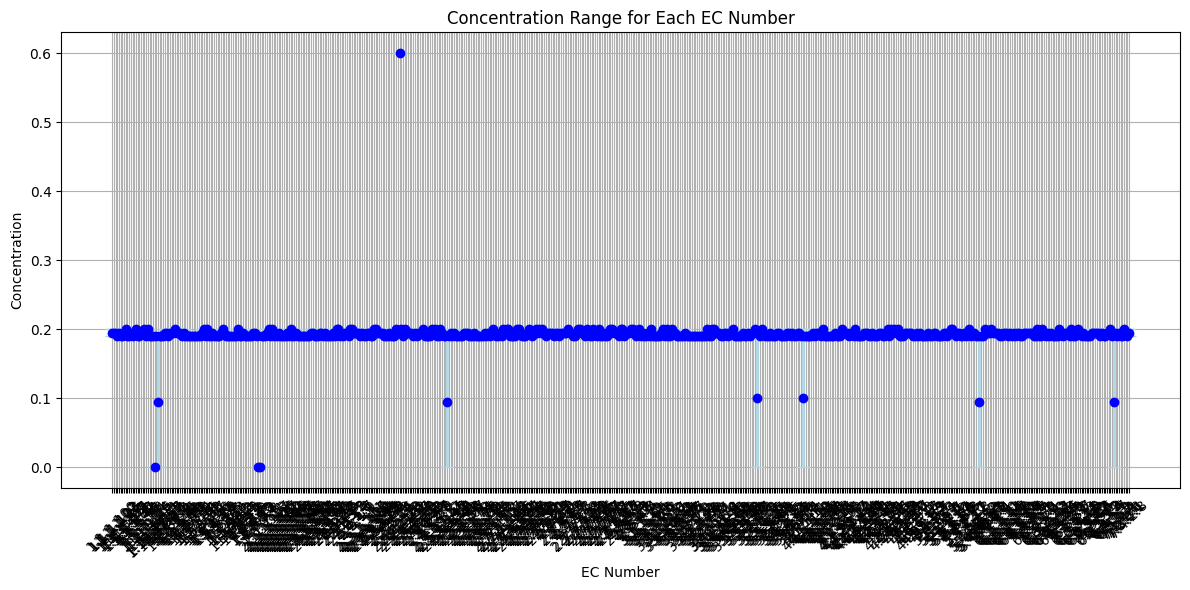

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = coec.copy()

# Calculate the range of concentrations for each EC number
ec_range = df.groupby('ec')['CoCl2'].agg(['min', 'max']).reset_index()
ec_range.columns = ['EC Number', 'Min Concentration', 'Max Concentration']

# Create the plot
plt.figure(figsize=(12, 6))

# Plot the range of concentrations as error bars
plt.errorbar(
    x=ec_range['EC Number'],
    y=(ec_range['Max Concentration'] + ec_range['Min Concentration']) / 2,  # Mean concentration for y-axis
    yerr=[(ec_range['Max Concentration'] - ec_range['Min Concentration']) / 2],  # Error bars as half the range, can change to stand. dev. later
    fmt='o',
    color='blue',
    ecolor='lightblue',
    elinewidth=2,
    capsize=5,
    label='Concentration Range'
)

# Customize plot appearance
plt.xticks(rotation=45)
plt.xlabel('EC Number')
plt.ylabel('Concentration')
plt.title('Concentration Range for Each EC Number')
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()


In [36]:
import pandas as pd
import plotly.graph_objects as go

df = coec.copy()

# Calculate the range of concentrations for each EC number
ec_range = df.groupby('ec')['CoCl2'].agg(['min', 'max']).reset_index()
ec_range.columns = ['EC Number', 'Min Concentration', 'Max Concentration']

# Create an interactive plot with Plotly
fig = go.Figure()

# Add error bars
fig.add_trace(go.Scatter(
    x=ec_range['EC Number'],
    y=(ec_range['Max Concentration'] + ec_range['Min Concentration']) / 2,  # Mean concentration for y-axis
    error_y=dict(
        type='data',
        symmetric=False,
        array=(ec_range['Max Concentration'] - ec_range['Min Concentration']) / 2,
        arrayminus=(ec_range['Max Concentration'] - ec_range['Min Concentration']) / 2
    ),
    mode='markers',
    marker=dict(color='blue'),
    text=ec_range['EC Number'],  # Hover text
    hoverinfo='text',  # Show hover text
    name='Concentration Range'
))

# Update layout
fig.update_layout(
    title='Concentration Range for Each EC Number',
    xaxis_title='EC Number',
    yaxis_title='Concentration',
    xaxis_tickangle=-45
)

# Show interactive plot
fig.show()


### MAGs, ko2ec

In [ ]:
import pandas as pd
import os
import requests
import re

DATA_DIR = "~/Desktop/code/data"

# Load ko-annotated MAG (LCHF)
mag = pd.read_csv(os.path.join(DATA_DIR, "Thermodesulfo_MAG.csv"))
mag = mag.dropna()
ko_list = mag["KO"].to_list()

# ko2ec function
def fetch_and_extract_ec_numbers(ko):
    url = f'https://rest.kegg.jp/get/ko:{ko}'
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.text
        ec_numbers = re.findall(r'\b\d+\.\d+\.\d+\.\d+\b', data)
        return ec_numbers
    else:
        print(f"Failed to retrieve data for KO: {ko}")
        return []

# Loop through the list of KO numbers and extract EC numbers
all_ec_numbers = {}
for ko in ko_list:
    ec_numbers = fetch_and_extract_ec_numbers(ko)
    all_ec_numbers[ko] = ec_numbers

data_for_df = []
for ko, ec_numbers in all_ec_numbers.items():
    for ec in ec_numbers:
        data_for_df.append({'KO': ko, 'EC Number': ec})
df = pd.DataFrame(data_for_df)

cp = df.copy()
x = "LC_bin_0"
y = "unknown"
z = "Thermodesulfovibrionales"
s = "MAG"
cp[["taxon_id","media_id", "species", "source"]] = x, y, z, s
cp = cp.rename(columns={"EC Number":"ec"})

#cp.to_csv(os.path.join(DATA_DIR, "test.csv"))
cp.head()

In [2]:
taxa = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)
cp = pd.read_csv(os.path.join(DATA_DIR, "test.csv"))
test = cp[["media_id", "species", "taxon_id", "source", "ec"]]
test.head()

,media_id,species,taxon_id,source,ec
0,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.3
1,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.3
2,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.22
3,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.22
4,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.23


In [3]:
data = [test, taxa]
model = pd.concat(data)

#model.to_csv(os.path.join(DATA_DIR, "test_model.csv"), index=False)
model

,media_id,species,taxon_id,source,ec
0,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.3
1,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.3
2,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.22
3,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.22
4,unknown,Thermodesulfovibrionales,LC_bin_0,MAG,1.1.1.23
...,...,...,...,...,...
4369540,J1236,Thermus thermophilus,274,ncbi,6.1.1.16
4369541,J1236,Thermus thermophilus,274,ncbi,2.5.1.145
4369542,J1236,Thermus thermophilus,274,ncbi,1.1.1.37
4369543,J1236,Thermus thermophilus,274,ncbi,5.2.1.8


### FENIX21

In [2]:
import modules.utils as utils
directory = os.path.join(DATA_DIR, "all")
bins = utils.process_directory(directory)
bins.head()


Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.001.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.002.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.004.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.005.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.006.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.008.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.009.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/Users/jakel/Desktop/code/data/all\KBase_derived_Bin.011.fastaBA_F_extracted_bins.AssemblySet_DRAM.gff
Processing file: C:/User

,filename,seqname,source,feature,ID,product,ec,ko
0,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1052_length_11999_cov_4.021266,KBase,gene,NODE_1052_length_11999_cov_4.021266_1,,N/A,N/A
1,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1052_length_11999_cov_4.021266,KBase,gene,NODE_1052_length_11999_cov_4.021266_2,,N/A,N/A
2,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1052_length_11999_cov_4.021266,KBase,gene,NODE_1052_length_11999_cov_4.021266_3,uncharacterized protein,N/A,KO:K06944
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1052_length_11999_cov_4.021266,KBase,gene,NODE_1052_length_11999_cov_4.021266_4,release factor glutamine methyltransferase %5B...,2.1.1.297,KO:K02493
4,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1052_length_11999_cov_4.021266,KBase,gene,NODE_1052_length_11999_cov_4.021266_5,peptide chain release factor 1,N/A,KO:K02835


In [3]:
#bins.to_csv(os.path.join(DATA_DIR, 'FENIX21', 'FENIX21-bins.csv'), index=False)

In [4]:
test_ecs = bins.copy()
filter = test_ecs["ec"].str.contains("N/A")
test_ecs = test_ecs[~filter]
test_ecs.head()

,filename,seqname,source,feature,ID,product,ec,ko
3,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1052_length_11999_cov_4.021266,KBase,gene,NODE_1052_length_11999_cov_4.021266_4,release factor glutamine methyltransferase %5B...,2.1.1.297,KO:K02493
5,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1052_length_11999_cov_4.021266,KBase,gene,NODE_1052_length_11999_cov_4.021266_6,histidyl-tRNA synthetase %5BEC:6.1.1.21%5D,6.1.1.21,KO:K01892
13,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1109_length_11407_cov_3.999383,KBase,gene,NODE_1109_length_11407_cov_3.999383_3,type III pantothenate kinase %5BEC:2.7.1.33%5D,2.7.1.33,KO:K03525
29,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1114_length_11353_cov_4.046645,KBase,gene,NODE_1114_length_11353_cov_4.046645_8,tRNA-uridine 2-sulfurtransferase %5BEC:2.8.1.1...,2.8.1.13,KO:K00566
36,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,NODE_1141_length_11155_cov_4.291892,KBase,gene,NODE_1141_length_11155_cov_4.291892_2,branched-chain amino acid aminotransferase %5B...,2.6.1.42,KO:K00826


#### Merge EC data w/ taxa2ec-final

In [2]:
# dataframes
train = pd.read_csv(os.path.join(DATA_DIR, "taxa2ec-final.csv"), low_memory=False)
test = pd.read_csv(os.path.join(DATA_DIR, 'FENIX21', 'FENIX21-bins.csv'), low_memory=False)

In [3]:
# weird na values, just make some filters
test["ec"] = test["ec"].astype(str).dropna()
NaN = test["ec"].str.contains("NaN")
nan = test["ec"].str.contains("nan")
test = test[~NaN & ~nan]

# start formatting to merge with taxa2ec-final
test["media_id"] = "unknown"
test["species"] = "unknown" ### can update with taxonomy predictions from the KBase workspace
test = test.rename(columns={"filename": "taxon_id", "ID": "node"})

# subset
test = test[["media_id","species","taxon_id", "source", "ec"]]

test.head()

,media_id,species,taxon_id,source,ec
3,unknown,unknown,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,KBase,2.1.1.297
5,unknown,unknown,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,KBase,6.1.1.21
13,unknown,unknown,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,KBase,2.7.1.33
29,unknown,unknown,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,KBase,2.8.1.13
36,unknown,unknown,KBase_derived_Bin.001.fastaBA_F_extracted_bins...,KBase,2.6.1.42


In [4]:
# Concat
frames = train, test
ml_input = pd.concat(frames)

#ml_input.to_csv(os.path.join(DATA_DIR, "ml_input.csv"), index=False)
ml_input

,media_id,species,taxon_id,source,ec
0,1a,Comamonas testosteroni,285,uniprot,2.6.1.1
1,1a,Comamonas testosteroni,285,uniprot,4.1.1.12
2,1a,Comamonas testosteroni,285,uniprot,1.13.11.74
3,1a,Comamonas testosteroni,285,uniprot,1.13.11.76
4,1a,Comamonas testosteroni,285,uniprot,1.14.13.23
...,...,...,...,...,...
42861,unknown,unknown,KBase_derived_Bin.028.fastaBA_F_extracted_bins...,KBase,2.7.1.36
42867,unknown,unknown,KBase_derived_Bin.028.fastaBA_F_extracted_bins...,KBase,6.3.4.3
42869,unknown,unknown,KBase_derived_Bin.028.fastaBA_F_extracted_bins...,KBase,1.5.98.1
42872,unknown,unknown,KBase_derived_Bin.028.fastaBA_F_extracted_bins...,KBase,2.7.4.3
